In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [3]:
# 1. Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
train_dir = '../../data4/train'
val_dir   = '../../data4/validation'
test_dir  = '../../data4/test'

# 2. Data Generators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                   horizontal_flip=True, 
                                   vertical_flip=True)

val_datagen   = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 5999 images belonging to 4 classes.
Found 1672 images belonging to 4 classes.
Found 1672 images belonging to 4 classes.


In [4]:
# 3. Load Pretrained ResNet50 for Feature Extraction
base_model = ResNet50(weights='imagenet', include_top=False, 
                      input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
feature_extractor = Model(inputs=base_model.input, outputs=x)
for layer in base_model.layers:
    layer.trainable = False

# 4. Feature Extraction Function
def extract_features_and_labels(model, generator):
    features_list = []
    labels_list = []
    generator.reset()
    num_batches = int(np.ceil(generator.samples / generator.batch_size))
    for _ in range(num_batches):
        X_batch, y_batch = next(generator)
        batch_features = model.predict(X_batch)
        features_list.append(batch_features)
        labels_list.append(y_batch)
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return features, labels

In [5]:
# 5. Extract Features
X_train, y_train = extract_features_and_labels(feature_extractor, train_generator)
X_val, y_val     = extract_features_and_labels(feature_extractor, val_generator)
X_test, y_test   = extract_features_and_labels(feature_extractor, test_generator)

# Convert one-hot to class indices if necessary
y_train_indices = np.argmax(y_train, axis=1)
y_val_indices   = np.argmax(y_val, axis=1)
y_test_indices  = np.argmax(y_test, axis=1)

# 6. Train Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train_indices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step
1/1 ━━━━━━━━━━━━━━━━━━

RandomForestClassifier(random_state=42)

In [6]:
# 7. Evaluation on Validation Set
y_val_pred = rf_classifier.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val_indices, y_val_pred))
print("Validation Classification Report:")
print(classification_report(y_val_indices, y_val_pred))

# 8. Final Test Evaluation
y_test_pred = rf_classifier.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test_indices, y_test_pred))
print("Test Classification Report:")
print(classification_report(y_test_indices, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test_indices, y_test_pred))


Validation Accuracy: 0.7374401913875598
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.57      0.60       450
           1       0.69      0.70      0.69       450
           2       0.72      0.86      0.78       322
           3       0.91      0.85      0.88       450

    accuracy                           0.74      1672
   macro avg       0.74      0.75      0.74      1672
weighted avg       0.74      0.74      0.74      1672


Test Accuracy: 0.736244019138756
Test Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.58      0.60       450
           1       0.71      0.71      0.71       450
           2       0.71      0.86      0.78       322
           3       0.90      0.84      0.87       450

    accuracy                           0.74      1672
   macro avg       0.74      0.75      0.74      1672
weighted avg       0.74      0.74      0.74      

Macro-average ROC AUC: 0.9234296542529661
Micro-average ROC AUC: 0.9305250113512359


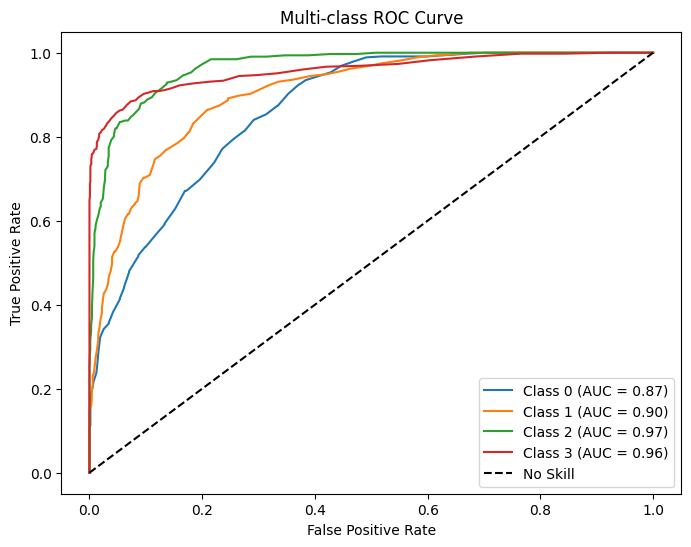

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Get predicted probabilities
y_test_prob = rf_classifier.predict_proba(X_test)

# 2. Binarize the true labels (if they are not already one-hot)
num_classes = train_generator.num_classes  # or manually set
y_test_bin = label_binarize(y_test_indices, classes=range(num_classes))

# 3. Compute ROC-AUC scores
macro_roc_auc = roc_auc_score(y_test_bin, y_test_prob, multi_class='ovr', average='macro')
micro_roc_auc = roc_auc_score(y_test_bin, y_test_prob, multi_class='ovr', average='micro')

print("Macro-average ROC AUC:", macro_roc_auc)
print("Micro-average ROC AUC:", micro_roc_auc)

# 4. Plot ROC curves for each class
fpr = {}
tpr = {}
roc_auc_for_each_class = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    roc_auc_for_each_class[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], 
             label='Class {} (AUC = {:.2f})'.format(i, roc_auc_for_each_class[i]))

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()
